In [1]:
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
import tensorflow_addons as tfa
import sys
import os
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
if os.path.abspath('../../tt_keras') not in sys.path:
    sys.path.append(os.path.abspath('../../tt_keras'))
if os.path.abspath('../../tf2-gradient-checkpointing') not in sys.path:
    sys.path.append(os.path.abspath('../../tf2-gradient-checkpointing'))

if os.path.abspath('../../t3f') not in sys.path:
    sys.path.append(os.path.abspath('../../t3f'))

import automatic_speech_recognition as asr
from automatic_speech_recognition.utils import (wrap_call_methods, select_layers, 
                                                remove_dropouts,
                                                merge_dense_dense, merge_dense_lstm,
                                                merge_neighbor_layers, get_renamed_model,
                                                get_model_prefixes)
from automatic_speech_recognition.dataset import ModelOutputsDataset
from automatic_speech_recognition.model import maxvol
import time
from datetime import datetime
import argparse
import pickle
from checkpointing import checkpointable
from functools import partial
from transform_model import transform
from tqdm import tqdm
from tensorflow.keras import layers
import seaborn as sns
sns.set()

from collections.abc import Iterable, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
from h5_to_tflite import TF_CUSTOM_OBJECTS

from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.mixed_precision import experimental as mixed_precision

import horovod.tensorflow.keras as hvd
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)
#%load_ext tensorboard
#%tensorboard --logdir=./models/ --port=32779

In [2]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold'}

matplotlib.rc('font', **font)

In [3]:
# !!!ONLY RUN ONCE AT THE START
deepspeech = asr.model.load_mozilla_deepspeech('./data/myfrozen.pb', verbose=False)
deepspeech.summary()

load graph
Instructions for updating:
Use tf.gfile.GFile.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 26)          0         
_________________________________________________________________
lambda (Lambda)              (None, None, 26, 1)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, 26, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, 1, 2048)     1013760   
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 2048)        0         
_________________________________________________________________
re_lu (ReLU)                 (None, None, 2048)        0         
________________________________________________________________

## Define pipeline code

In [4]:
def get_pipeline(model, optimizer=None):
    alphabet = asr.text.Alphabet(lang='en')
    features_extractor = asr.features.TfMFCC(
        features_num=26,
        winlen=0.032,
        winstep=0.02,
    )
    if not optimizer:
        optimizer = tf.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
    decoder = asr.decoder.GreedyDecoder()
    pipeline = asr.pipeline.CTCPipeline(
        alphabet, features_extractor, model, optimizer, decoder
    )
    return pipeline

def get_optimizer():
    opt_instance = tfa.optimizers.NovoGrad(0.0, beta_1=0.95, beta_2=0.5, weight_decay=0.001)
    return hvd.DistributedOptimizer(opt_instance)

def find_activations(model, dataset_idx, size_limit=None, verbose=False):
    dataset = asr.dataset.Audio.from_csv(dataset_idx, batch_size=1, use_filesizes=True, librosa_read=False)
    dataset.sort_by_length()
    dataset.shuffle_indices()
    dataset = ModelOutputsDataset(get_pipeline(model), dataset)

    activations = []
    num_activations = 0
    for i, (_, output) in enumerate(dataset):
        output = (output
                  .cpu()
                  .numpy()
                  .reshape(-1, output.shape[-1]))
        activations.append(output)
        num_activations += len(activations[-1])    
        if size_limit is not None and num_activations >= size_limit:
            break
        if verbose and i % 50 == 0:
            print(f"Calculated batch {i} out of {len(dataset)}")
    
    activations = np.concatenate(activations)
    if size_limit is not None:
        activations = activations[:size_limit]
        
    return activations

def svd_activations(model, dataset_idx, num_rows=None, verbose=False, return_activations=False, **kwargs):
    activations = find_activations(model, dataset_idx, size_limit=num_rows, verbose=verbose)
    
    if return_activations:
        return np.linalg.svd(activations, **kwargs), activations
    else:
        return np.linalg.svd(activations, **kwargs)

In [5]:
!mkdir layer_activations

mkdir: cannot create directory ‘layer_activations’: File exists


In [6]:
name_mapping = {
    're_lu': 'Dense 1',
    're_lu_1': 'Dense 2',
    're_lu_2': 'Dense 3',
    're_lu_3': 'Dense 4',
    'lstm_1': 'LSTM',
}

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


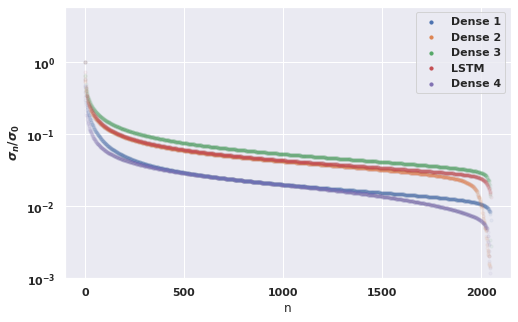

In [7]:
dense_tails = ['conv2d', 'dense_2', 'dense_3', 'dense_4', 'dense_5']
singular_values = []

# fig, axes = plt.subplots(5, 1, figsize=(13, 40))
# axes = axes.ravel()
# for prefix_model, tail_name, ax in zip(get_model_prefixes(deepspeech, tail_names=dense_tails), dense_tails, axes):
# #     (_, cur_sigmas, vt), activs = svd_activations(prefix_model, './data/dev-clean-index.csv', 100000, full_matrices=False, return_activations=True)
# #     singular_values.append(cur_sigmas)
# #     np.save(f'layer_activations/{tail_name}.npy', activs)
# #     np.save(f'layer_activations/vt_{tail_name}.npy', vt)
# #     np.save(f'./layer_activations/sing_vals_{tail_name}.npy', cur_sigmas)
#     cur_sigmas = np.load(f'./layer_activations/sing_vals_{tail_name}.npy')

#     ax.set_title(f'Singular values for {tail_name}')
#     ax.set_yscale('log')
#     ax.scatter(range(len(cur_sigmas)), cur_sigmas/cur_sigmas[0], s=2)
#     ax.set_ylabel('$\sigma_n / \sigma_0$')
#     ax.set_xlabel('n')
relu_tails = ['re_lu', 're_lu_1', 're_lu_2', 'lstm_1', 're_lu_3']
singular_values = []

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
axes = [ax] * len(relu_tails)
for prefix_model, tail_name, ax in zip(get_model_prefixes(deepspeech, tail_names=relu_tails), relu_tails, axes):
#     (_, cur_sigmas, vt), activs = svd_activations(prefix_model, './data/dev-clean-index.csv', 100000, full_matrices=False, return_activations=True)
#     singular_values.append(cur_sigmas)
#     np.save(f'layer_activations/{tail_name}.npy', activs)
#     np.save(f'layer_activations/vt_{tail_name}.npy', vt)
#     np.save(f'./layer_activations/sing_vals_{tail_name}.npy', cur_sigmas)
    cur_sigmas = np.load(f'./layer_activations/sing_vals_{tail_name}.npy')
    
#     ax.set_title(f'Singular values for activations of different layers')
    ax.set_yscale('log')
    ax.scatter(range(len(cur_sigmas)), cur_sigmas/cur_sigmas[0], s=10, alpha=0.05, label=name_mapping[tail_name])
    ax.set_ylabel('$\sigma_n / \sigma_0$')
    ax.set_xlabel('n')
ax.set_ylim([1e-3, None])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.savefig('./singular_plot.pdf')

### Get the mapping from cropped svd rank to spectral loss of approximation

In [8]:
import pickle

for filename in os.listdir('./layer_activations'):
    if filename.startswith('sing_vals_'):
        approximation_losses = {}
        name = filename[len('sing_vals_'):-4]
        sigmas = np.load(f'layer_activations/sing_vals_{name}.npy')
        sigmas_sq = sigmas ** 2
        
        approximation_losses['frobenius'] = np.sqrt(np.cumsum(sigmas_sq[::-1])[::-1])
        approximation_losses['rel_frobenius'] = approximation_losses['frobenius'] / np.sqrt(sigmas_sq.sum())
        approximation_losses['spectral'] = sigmas
        
        with open(f'./maxvol_stats/svd_approx_errors_{name}.pickle', 'wb+') as f:
            pickle.dump(approximation_losses, f)

### Calculate maxvol rows

In [9]:
# ! pip install maxvolpy

# from maxvolpy.maxvol import rect_maxvol, maxvol
# import os
# import numpy as np

# ranks = [100, 300, 500, 700, 750, 1000, 1200, 1300, 1400, 1500, 1700] 
# for rank in ranks:
#     for filename in os.listdir('./layer_activations'):
#         if not filename.startswith('vt_'):
#             continue
#         name = filename[3:-4]
#         vt = np.load(f'./layer_activations/{filename}')
#         v = vt[:rank].T
#         piv, C = rect_maxvol(v, start_maxvol_iters=1000, tol=1.01, maxK=2*rank)
#         np.save(f"./layer_activations/2vol_maxvolrows_{name}_r{rank}.npy", piv)
#         piv, C = maxvol(v, max_iters=1000, tol=1.01)
#         np.save(f"./layer_activations/1vol_maxvolrows_{name}_r{rank}.npy", piv)

### Maxvol for deepspeech

In [10]:
def evaluate(model, dataset_idx='./data/dev-clean-index.csv'):
    pipeline = get_pipeline(model)
    dataset = asr.dataset.Audio.from_csv(dataset_idx, batch_size=10, use_filesizes=True, librosa_read=False)
    dataset.sort_by_length()
    pipeline.compile_model()

    dataset = pipeline.wrap_preprocess(dataset)
    loss = model.evaluate(dataset)
    
    test_dataset = asr.dataset.Audio.from_csv(dataset_idx, batch_size=10, use_filesizes=True, librosa_read=False)
    dataset.sort_by_length()
    wer, cer = asr.evaluate.calculate_error_rates(pipeline, test_dataset)
    return loss, wer, cer

def get_maxvolled_deepspeech(deepspeech_model, rank, tol, change_layers=None, maxvol_type='2vol'):
    assert maxvol_type in ('2vol', '1vol')
    if change_layers is None:
        change_layers = ['dense_2', 'dense_3', 'dense_4', 'lstm_1']
    if isinstance(rank, int):
        rank = {layer_name: rank for layer_name in change_layers}
    
    # clone model and rename layers to avoid problems arising from graph manipulations
    deepspeech_ = get_renamed_model(deepspeech_model)
    new_model_layers = []
    skip_next_layer = False
    for i, layer in enumerate(deepspeech_.layers):
        if skip_next_layer: 
            skip_next_layer = False
            continue

        if deepspeech_model.layers[i].name == 'lstm_1' and 'lstm_1' in change_layers:
            layer_rank = rank['lstm_1']
            compact_v = np.load(f'./layer_activations/vt_lstm_1.npy')[:layer_rank].T
            maxvol_idxs = np.load(f'./layer_activations/{maxvol_type}_tol{tol}_maxvolrows_lstm_1_r{layer_rank}.npy')
            new_model_layers.extend(maxvol.get_maxvol_decomposed_lstm(layer, compact_v, maxvol_idxs))
            change_layers.remove('lstm_1')
        elif deepspeech_model.layers[i].name in change_layers:
            assert isinstance(layer, keras.layers.Dense), f"Specified layer should be dense and it is {deepspeech_.layers[i]}"
            assert isinstance(deepspeech_.layers[i + 1], keras.layers.ReLU), f"Specified dense should be followed by ReLu instead is {deepspeech_.layers[i+1]}"
            relu_name = deepspeech_model.layers[i + 1].name
            layer_rank = rank[relu_name]
            
            compact_v = np.load(f'./layer_activations/vt_{relu_name}.npy')[:layer_rank].T
            maxvol_idxs = np.load(f'./layer_activations/{maxvol_type}_tol{tol}_maxvolrows_{relu_name}_r{layer_rank}.npy')
            new_model_layers.extend(maxvol.get_maxvol_decomposed_dense(dense_layer=layer, 
                                                                       activation=deepspeech_model.layers[i + 1], 
                                                                       compact_v=compact_v,
                                                                       maxvol_idxs=maxvol_idxs))        
            skip_next_layer = True
            change_layers.remove(deepspeech_model.layers[i].name)
        else:
            new_model_layers.append(layer)
    assert len(change_layers) == 0, f"{change_layers} were not found in model and replaced"
    
    result_model = keras.Sequential()
    result_model.add(keras.Input(shape=deepspeech_model.input_shape[1:]))
    for layer in new_model_layers:
        result_model.add(layer)
    result_model = remove_dropouts(result_model)
    result_model = merge_neighbor_layers(result_model)
    result_model = get_renamed_model(result_model)
    return result_model

def _layers_to_name(layers_to_change):
    result = ''
    if 'lstm_1' in layers_to_change:
        result = 'lstm'
    denses = []
    for entry in layers_to_change:
        if entry.startswith('dense_'):
            denses.append(entry[len('dense_'):])
    denses = sorted(denses)    
    if len(denses) > 0:
        if len(result) > 0:
            result += '_'
        result += 'desnse' + ''.join(denses)
    return result

def get_maxvol_stats(ranks, deepspeech_model, change_layers=None, maxvol_type='2vol', tol=1.01, verbose=False):
    assert maxvol_type in ('2vol', '1vol')
    losses = []
    wers = []
    cers = []
    for rank in ranks:
        result_model = get_maxvolled_deepspeech(deepspeech_model, rank, tol, change_layers, maxvol_type)
        result_model.save(f'./models/{_layers_to_name(change_layers)}_{maxvol_type}_tol{tol}_maxvolled_deepspeech_r{rank}.h5')
        result_model = keras.models.load_model(f'./models/{_layers_to_name(change_layers)}_{maxvol_type}_tol{tol}_maxvolled_deepspeech_r{rank}.h5')
        result_model.call = tf.function(result_model.call, experimental_relax_shapes=True)
        if verbose:
            print(f"After maxvol with rank {rank} and tol {tol} got model summary:")
            result_model.summary()
        loss, wer, cer = evaluate(result_model)
        
        losses.append(loss)
        wers.append(wer)
        cers.append(cer)
    return losses, wers, cers

In [11]:
# ranks = list(reversed([100, 300, 500, 700, 1000, 1200, 1400, 1500, 1700]))

# for tol in [1.01, 1.05, 1.1]:
#     for maxvol_type in ('2vol', '1vol'):
#         for change_layer in ('lstm_1', 'dense_2', 'dense_3', 'dense_4'):
# #             if os.path.exists(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_wers.npy'):
# #                 print(f"Skip {maxvol_type} {change_layer} layers")
# #                 continue
# #             else:
# #                 np.save(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_wers.npy', np.array([0,0,0,0]))

#             losses, wers, cers = get_maxvol_stats(ranks, deepspeech, 
#                                                   change_layers=[change_layer], 
#                                                   maxvol_type=maxvol_type, 
#                                                   tol=tol,
#                                                   verbose=True)
# #             np.save(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_wers.npy', np.array(wers))
# #             np.save(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_cers.npy', np.array(cers))
# #             np.save(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_losses.npy', np.array(losses))
# #             import sys
# #             sys.exit(0)
        

# for tol in [1.01, 1.05, 1.1]:
#     for maxvol_type in ('2vol', '1vol'):
#         losses, wers, cers = get_maxvol_stats(ranks, deepspeech, 
#                                               change_layers=('lstm_1', 'dense_2', 'dense_3', 'dense_4'), 
#                                               maxvol_type=maxvol_type, 
#                                               tol=tol,
#                                               verbose=True)
#         np.save(f'./maxvol_stats/{maxvol_type}_tol{tol}_wers.npy', np.array(wers))
#         np.save(f'./maxvol_stats/{maxvol_type}_tol{tol}_cers.npy', np.array(cers))
#         np.save(f'./maxvol_stats/{maxvol_type}_tol{tol}_losses.npy', np.array(losses))

In [12]:
# !mkdir maxvol_stats
# !sbatch subm_python_small.sh calc_stats_svd_maxvol_.py

## Plot results after changing one layer

In [19]:
convert_name = {
    'losses': 'loss',
    'wers': 'wer',
    'cers': 'cer'
}

original_values = {
    'loss': 14.54,
    'wer': 0.1337,
    'cer': 0.0418,
    'inference_time': 1939270.0 
}

mapping = {
    'dense_2': 're_lu_1',
    'dense_3': 're_lu_2',
    'lstm_1': 'lstm_1',
    'dense_4': 're_lu_3'
}

def plot_metric_maxvol(metric_name, ranks, tol, maxvol_types, changed_layers, relative_values=False, maxvol_rank=False, plot_all=True, ax=None, ylimits=True):
    if ax is None:
        plt.figure(figsize=(10, 7))
        ax = plt.gca()
        
    assert metric_name in ('wers')
    
#     ax.set_title(f'{"Relative" if relative_values else ""} {convert_name[metric_name]}, maxvol tolerance={tol}')
    ax.set_ylabel(f'{"Relative" if relative_values else ""} Drop in WER')
    ax.set_xlabel('svd_ranks' if not maxvol_rank else 'maxvol rows num')
    for maxvol_type in maxvol_types:
        for change_layer in changed_layers:
            try:
                metrics = np.load(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_{metric_name}.npy') - original_values['wer']
                if relative_values:
                    metrics /= original_values[convert_name[metric_name]]
            except Exception as e:
                print(f"for {maxvol_type} maxvol {change_layer} files were not found")
                continue

            if maxvol_rank:
                maxvol_sizes = []
                for rank in ranks:
                    maxvol_sizes.append(np.load(f'./layer_activations/{maxvol_type}_tol{tol}_maxvolrows_{mapping[change_layer]}_r{rank}.npy').size)
                ax.plot(maxvol_sizes, metrics, '-*', label=f'decomposed {change_layer} {maxvol_type}')
            else: 
                ax.plot(ranks, metrics, '-*', label=f'decomposed {name_mapping[mapping[change_layer]]} maxvol {maxvol_type}')
            
    if plot_all:
        if '2vol' in maxvol_types:
            try:
                metrics = np.load(f'./maxvol_stats/2vol_tol{tol}_{metric_name}.npy')- original_values['wer']
                if relative_values:
                    metrics /= original_values[convert_name[metric_name]]
                ax.plot(ranks, metrics, '-*', label=f'!x=svd rank! decomposed Dense 2,3,4 and LSTM 2vol')
            except Exception as e:
                print(f"for {maxvol_type} maxvol all files were not found")
        if '1vol' in maxvol_types:
            try:
                metrics = np.load(f'./maxvol_stats/1vol_tol{tol}_{metric_name}.npy') - original_values['wer']
                if relative_values:
                    metrics /= original_values[convert_name[metric_name]]
                ax.plot(ranks, metrics, '-*', label=f'!x=svd rank! decomposed Dense 2,3,4 and LSTM 1vol')
            except Exception as e:
                print(f"for {maxvol_type} maxvol all files were not found")
        
    if not relative_values:
        original_metric_val = original_values[convert_name[metric_name]]
#         plt.plot([0, 2000], 
#                  [ 
#                  '--',
#                  label=f'Original {convert_name[metric_name]}')
        if ylimits and metric_name != 'losses':
#             ax.set_ylim([original_values['wer'], None])
            pass
        else:
            ax.set_ylim([0, None])
    else:
        ax.plot([0, 2000], [1, 1], '--', label=f'y = 1')
        ax.set_ylim([0, 10])
    
    ax.legend()
    ax.set_xlim([0, 2100])

In [20]:
# convert_name = {
#     'losses': 'loss',
#     'wers': 'wer',
#     'cers': 'cer'
# }

# original_values = {
#     'loss': 14.54,
#     'wer': 0.1337,
#     'cer': 0.0418,
#     'inference_time': 1939270.0 
# }

# mapping = {
#     'dense_2': 're_lu_1',
#     'dense_3': 're_lu_2',
#     'lstm_1': 'lstm_1',
#     'dense_4': 're_lu_3'
# }

# def plot_metric_maxvol(metric_name, ranks, tol, maxvol_types, changed_layers, relative_values=False, maxvol_rank=False, plot_all=True, ax=None, ylimits=True):
#     if ax is None:
#         plt.figure(figsize=(15, 9))
#         ax = plt.gca()
        
#     assert metric_name in ('wers', 'cers', 'losses')
    
#     ax.set_title(f'{"Relative" if relative_values else ""} {convert_name[metric_name]}, {"2 volume" if maxvol_type[0]=="2vol" else "1 volume"} maxvol tolerance={tol}, ')
#     ax.set_xlabel('svd_ranks' if not maxvol_rank else 'maxvol rows num')
#     for maxvol_type in maxvol_types:
#         for change_layer in changed_layers:
#             try:
#                 metrics = np.load(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_{metric_name}.npy')
#                 if relative_values:
#                     metrics /= original_values[convert_name[metric_name]]
#             except Exception as e:
#                 print(f"for {maxvol_type} maxvol {change_layer} files were not found")
#                 continue

#             if maxvol_rank:
#                 maxvol_sizes = []
#                 for rank in ranks:
#                     maxvol_sizes.append(np.load(f'./layer_activations/{maxvol_type}_tol{tol}_maxvolrows_{mapping[change_layer]}_r{rank}.npy').size)
#                 ax.plot(maxvol_sizes, metrics, '-*', label=f'decomposed {change_layer} {maxvol_type}')
#             else:
#                 ax.plot(ranks, metrics, '-*', label=f'decomposed {name_mapping[change_layer]}')
            
#     if plot_all:
#         if '2vol' in maxvol_types:
#             try:
#                 metrics = np.load(f'./maxvol_stats/2vol_tol{tol}_{metric_name}.npy')
#                 if relative_values:
#                     metrics /= original_values[convert_name[metric_name]]
#                 ax.plot(ranks, metrics, '-*', label=f'!x=svd rank! decomposed Dense 2,3,4 and LSTM')
#             except Exception as e:
#                 print(f"for {maxvol_type} maxvol all files were not found")
#         if '1vol' in maxvol_types:
#             try:
#                 metrics = np.load(f'./maxvol_stats/1vol_tol{tol}_{metric_name}.npy')
#                 if relative_values:
#                     metrics /= original_values[convert_name[metric_name]]
#                 ax.plot(ranks, metrics, '-*', label=f'!x=svd rank! decomposed Dense 2,3,4 and LSTM')
#             except Exception as e:
#                 print(f"for {maxvol_type} maxvol all files were not found")
        
#     if not relative_values:
#         original_metric_val = original_values[convert_name[metric_name]]
#         plt.plot([0, 2000], 
#                  [original_metric_val , original_metric_val], 
#                  '--',
#                  label=f'Original {convert_name[metric_name]}')
#         if ylimits and metric_name != 'losses':
# #             ax.set_ylim([0, 0.3])
#             pass
#         else:
#             ax.set_ylim([0, None])
#     else:
#         ax.plot([0, 2000], [1, 1], '--', label=f'y = 1')
#         ax.set_ylim([0, 10])
    
#     ax.legend()
#     ax.set_xlim([0, 2100])

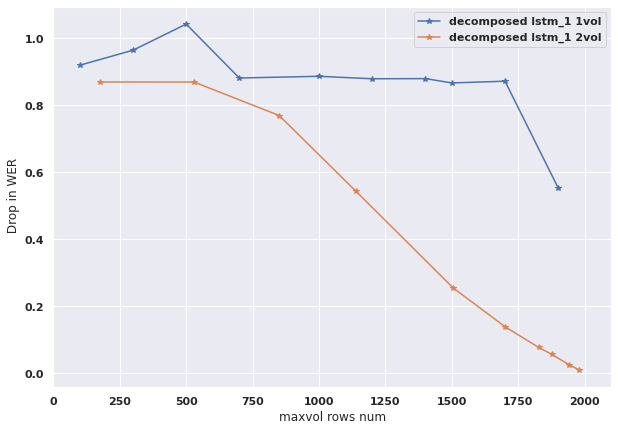

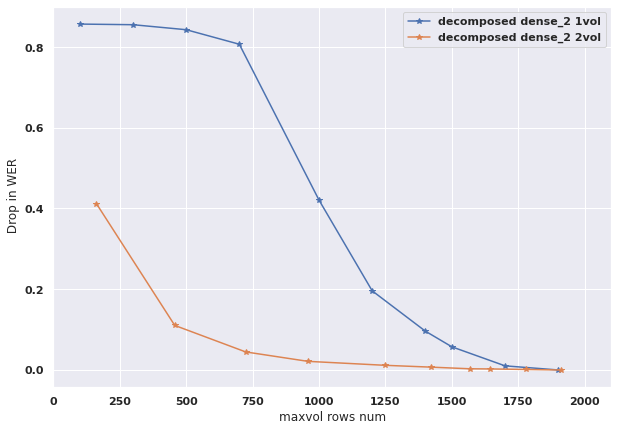

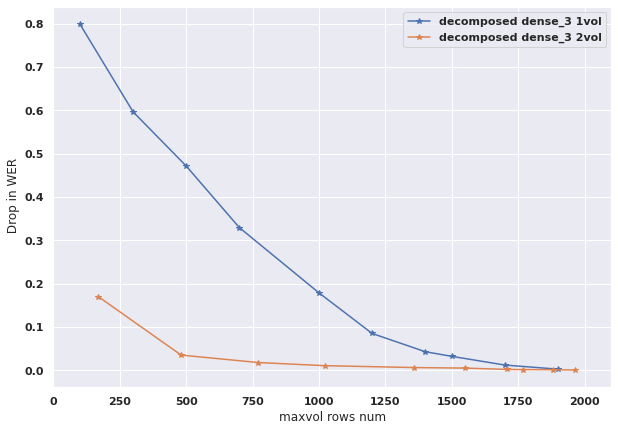

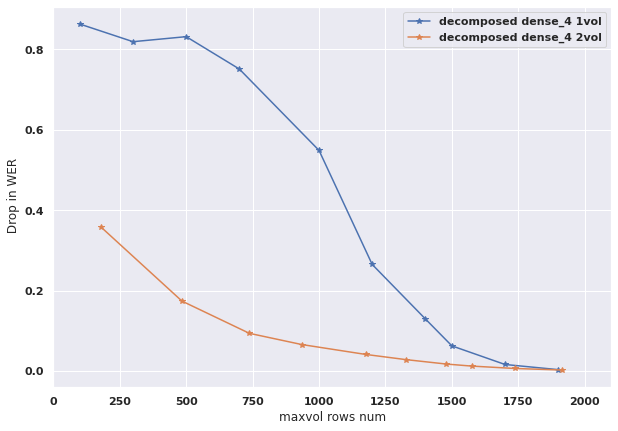

In [21]:
ranks = list(reversed([100, 300, 500, 700, 1000, 1200, 1400, 1500, 1700, 1900]))
tol = 1.01
plot_metric_maxvol('wers', ranks, tol,['1vol', '2vol'], ['lstm_1'], maxvol_rank=True, plot_all=False)
plot_metric_maxvol('wers', ranks, tol,['1vol', '2vol'], ['dense_2'],  maxvol_rank=True,plot_all=False)
plot_metric_maxvol('wers', ranks, tol,['1vol', '2vol'], ['dense_3'], maxvol_rank=True, plot_all=False)
plot_metric_maxvol('wers', ranks, tol,['1vol', '2vol'], ['dense_4'], maxvol_rank=True, plot_all=False)

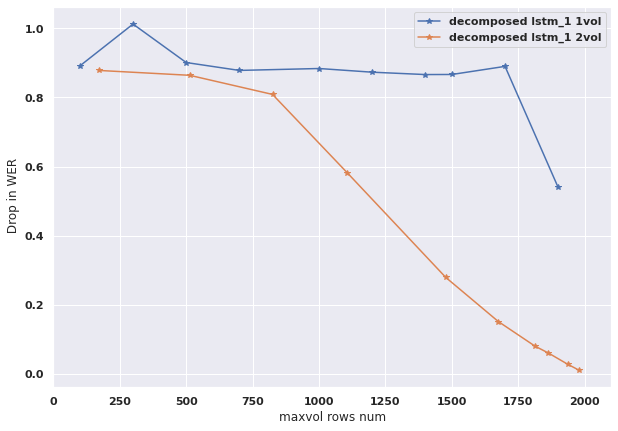

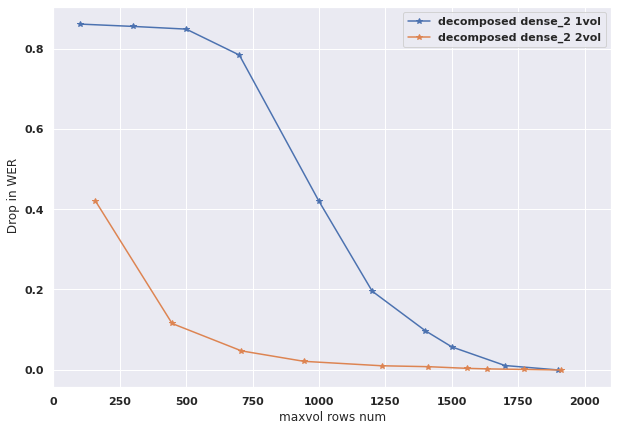

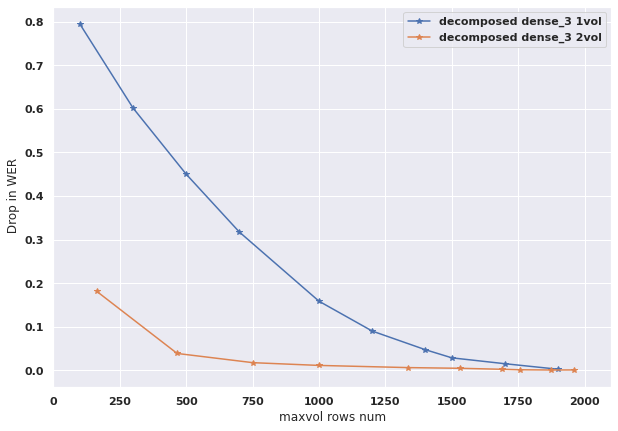

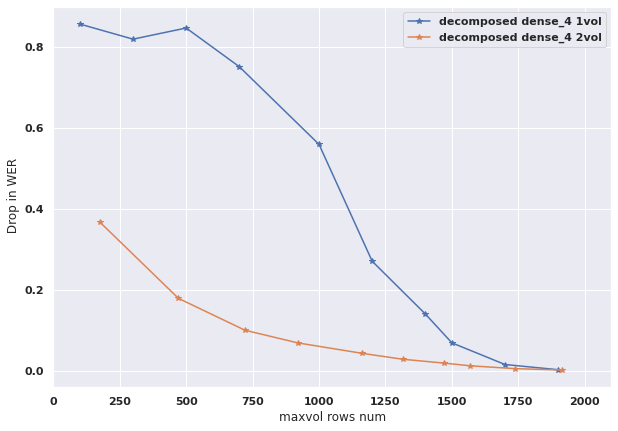

In [28]:
ranks = list(reversed([100, 300, 500, 700, 1000, 1200, 1400, 1500, 1700, 1900]))
tol = 1.05
plot_metric_maxvol('wers', ranks, tol,['1vol', '2vol'], ['lstm_1'], maxvol_rank=True, plot_all=False)
plot_metric_maxvol('wers', ranks, tol,['1vol', '2vol'], ['dense_2'],  maxvol_rank=True,plot_all=False)
plot_metric_maxvol('wers', ranks, tol,['1vol', '2vol'], ['dense_3'], maxvol_rank=True, plot_all=False)
plot_metric_maxvol('wers', ranks, tol,['1vol', '2vol'], ['dense_4'], maxvol_rank=True, plot_all=False)

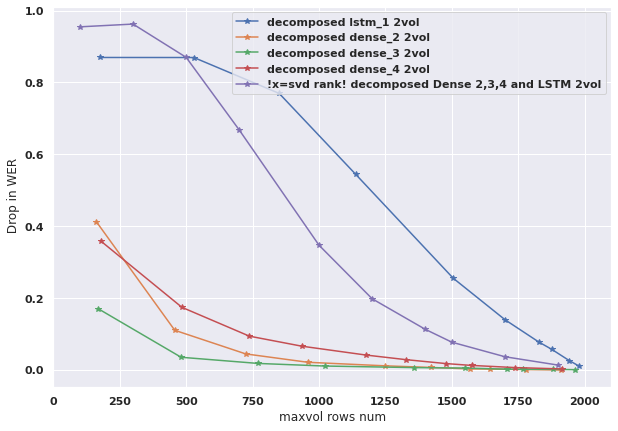

In [29]:
ranks = list(reversed([100, 300, 500, 700, 1000, 1200, 1400, 1500, 1700, 1900]))
tol = 1.01
# plot_metric_maxvol('losses', ranks, tol, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
# plot_metric_maxvol('losses', ranks, tol,['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'], relative_values=True)
plot_metric_maxvol('wers', ranks, tol,['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'], maxvol_rank=True)
# plot_metric_maxvol('cers', ranks, tol,['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])

Text(0.5, 1.0, 'WER, maxvol decopmosition with different tolerance parameter')

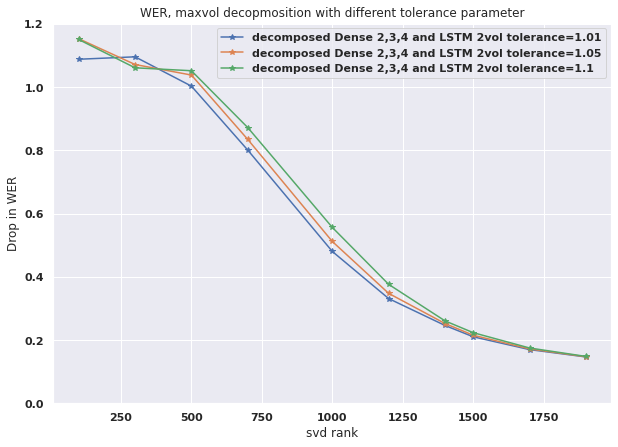

In [30]:
plt.figure(figsize=(10,7))
metric_name = 'wers'
for tol in [1.01, 1.05, 1.1]:
    wers = np.load(f'./maxvol_stats/2vol_tol{tol}_{metric_name}.npy')
    plt.plot(ranks, wers, '-*', label=f'decomposed Dense 2,3,4 and LSTM 2vol tolerance={tol}')
plt.xlabel('svd rank')
plt.ylabel('Drop in WER')
plt.ylim([0, None])
plt.legend()
plt.title('WER, maxvol decopmosition with different tolerance parameter')

As we can see there's no differece between different tolerance for maxvol. It is further proved in wer/speedup plot

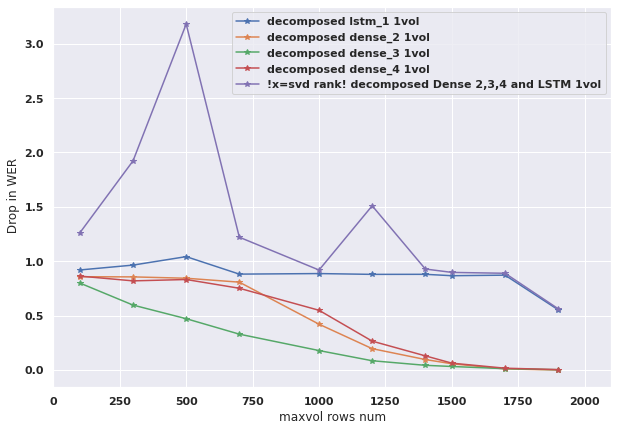

In [31]:
ranks = list(reversed([100, 300, 500, 700, 1000, 1200, 1400, 1500, 1700, 1900]))
tol = 1.01
# plot_metric_maxvol('losses', ranks, tol, ['1vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
# plot_metric_maxvol('losses', ranks, tol,['1vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'], relative_values=True)
plot_metric_maxvol('wers', ranks, tol,['1vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'], maxvol_rank=True)
# plot_metric_maxvol('cers', ranks, tol,['1vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])

1 vol is not suitable for decomposing lstm, which messes up the whole network perfomance.

In [32]:
def plot_metric(metric_name, x_name, changed_layers, maxvol_type, tol):
    plt.figure(figsize=(15, 9))
    ax = plt.gca()
    ax.set_title(f'{convert_name[metric_name]}, maxvol tolerance={tol}')
    ax.set_xlabel(x_name)
    ax.set_ylabel(convert_name[metric_name])
    
    for change_layer in changed_layers:
        metrics = np.load(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_{metric_name}.npy')
        if x_name == 'svd_rank':
            ax.plot(ranks, metrics, '-*', label=f'decomposed {change_layer} maxvol {maxvol_type}')
        else:
            with open(f'./maxvol_stats/svd_approx_errors_{mapping[change_layer]}.pickle', 'rb+') as f:
                approximation_losses = pickle.load(f)
            new_x = []
            for rank in ranks:
                new_x.append(approximation_losses[x_name][rank])
            ax.plot(new_x, metrics, '-*', label=f'decomposed {name_mapping[mapping[change_layer]]} {maxvol_type}')
    plt.legend()

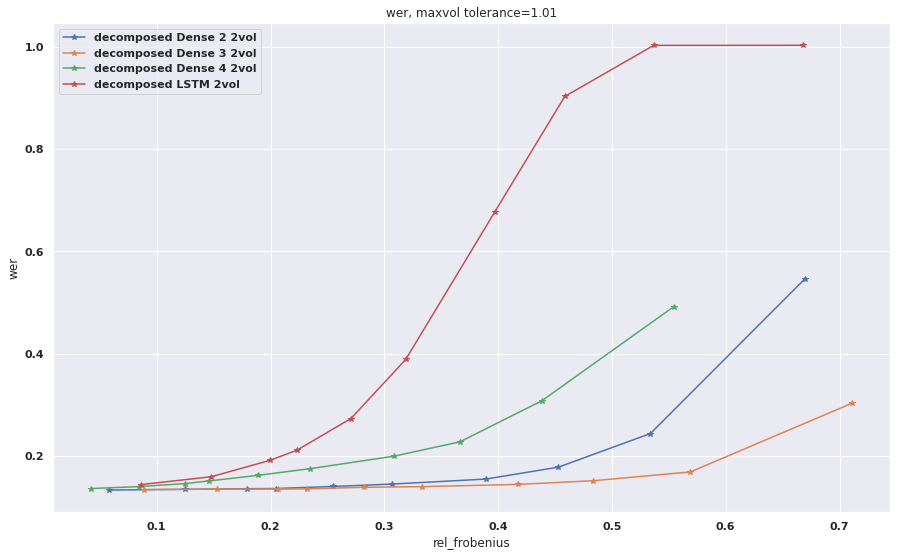

In [33]:
plot_metric('wers', 'rel_frobenius', ['dense_2', 'dense_3', 'dense_4', 'lstm_1'], '2vol', 1.01)

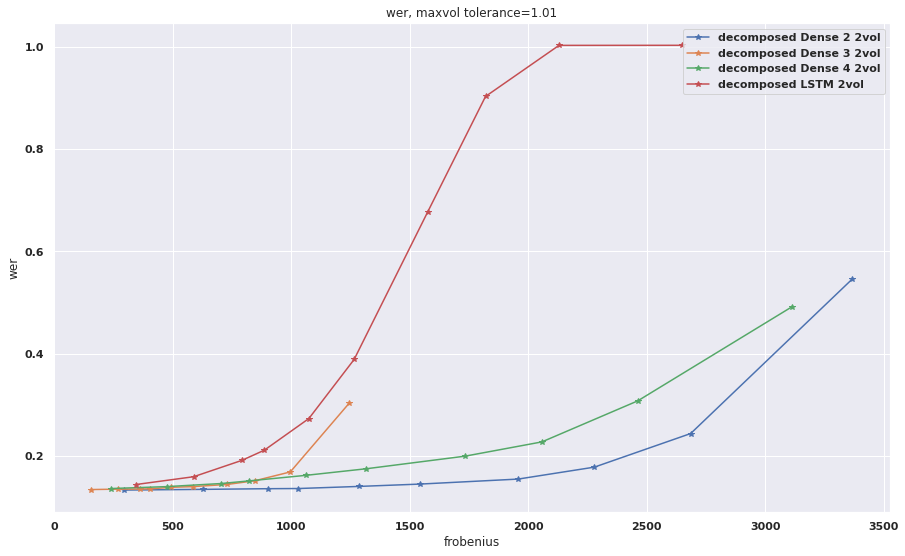

In [34]:
plot_metric('wers', 'frobenius', ['dense_2', 'dense_3', 'dense_4', 'lstm_1'], '2vol', 1.01)

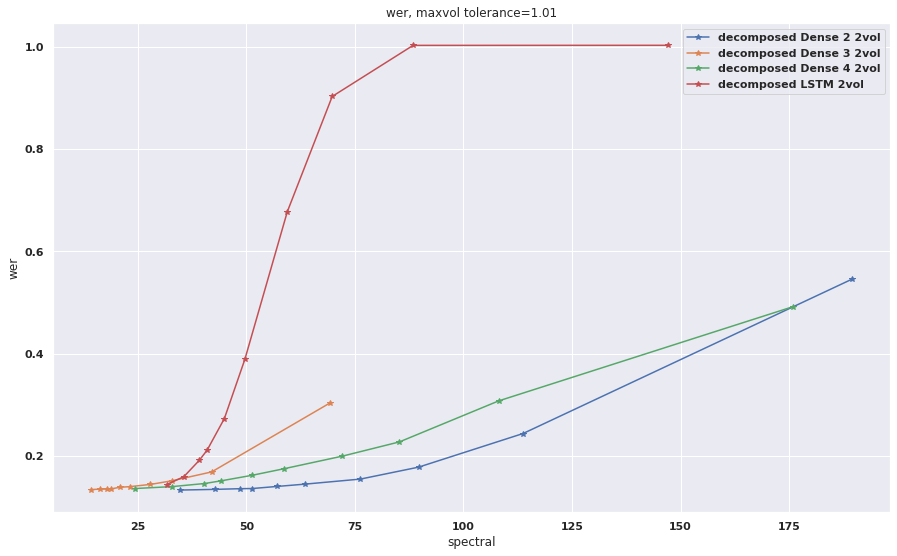

In [35]:
plot_metric('wers', 'spectral', ['dense_2', 'dense_3', 'dense_4', 'lstm_1'], '2vol', 1.01)

Another thing we can infer from the plots is that error after compression is not tied to the error of matrix approximation in Cropped SVD.

In [36]:
def plot_err_sum(metric_name):
    assert metric_name == 'wers'
    plt.figure(figsize=(14,10))

    ranks = list(reversed([100, 300, 500, 700, 1000, 1200, 1400, 1500, 1700, 1900]))
    one_layer_wers = []
    for change_layer in ['dense_2', 'dense_3', 'dense_4', 'lstm_1']:
        one_layer_wers.append(np.load(f'./maxvol_stats/{change_layer}_2vol_tol1.01_{metric_name}.npy') - original_values[convert_name[metric_name]])
    one_layer_wers = np.array(one_layer_wers)
    sum_wers = one_layer_wers.sum(axis=0)
    
    all_changed_wers = np.load(f'./maxvol_stats/2vol_tol1.01_{metric_name}.npy')- original_values[convert_name[metric_name]]

    plt.scatter(all_changed_wers, sum_wers)
    for i in range(len(ranks)):
        plt.text(all_changed_wers[i], sum_wers[i], str(ranks[i]))
    plt.ylabel(f'Sum of WER drops for decomposing one layer at a time')
    plt.xlabel(f'WER drop of a model with decomposed Dense 2,3,4 and LSTM')
#     plt.title(f'Error for maxvol decomposition of all layers')
#     plt.legend()
    
    plt.xlim([0, None])
    plt.ylim([0, None])
    plt.plot([0, 1000], [0, 1000])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show() 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


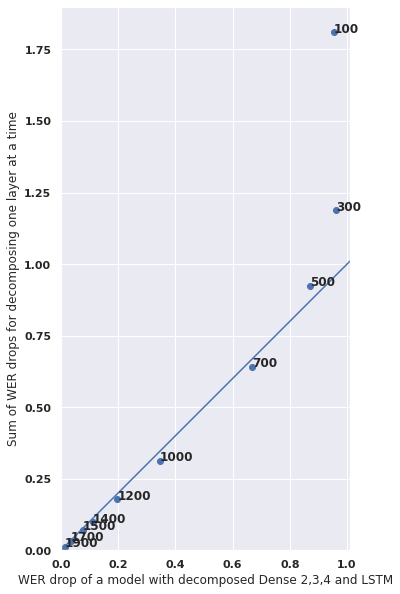

In [37]:
plot_err_sum('wers')

# Mixing maxvol decompositions of different rank

As we can see for big ranks change in wer caused by decomposition of all layers is almost equal to a sum of wer changes when we decompose each layer separately. We will exploit it to use different svd ranks for different layers.

In [38]:
special_rank_specs = {'special_r_900_500_1300_1700': {
    mapping['dense_2']: 900,
    mapping['dense_3']: 500,
    mapping['dense_4']: 1300,
    mapping['lstm_1']: 1700
}, 
'special_r_1000_700_1500_0': {
    mapping['dense_2']: 1000,
    mapping['dense_3']: 700,
    mapping['dense_4']: 1500
}, 
'special_r_1000_700_1500_1900': {
    mapping['dense_2']: 1000,
    mapping['dense_3']: 700,
    mapping['dense_4']: 1500,
    mapping['lstm_1']: 1900
}, 
'special_r_1200_1000_1700_0': {
    mapping['dense_2']: 1200,
    mapping['dense_3']: 1000,
    mapping['dense_4']: 1700
},
'special_r_1200_1000_1700_1900': {
    mapping['dense_2']: 1200,
    mapping['dense_3']: 1000,
    mapping['dense_4']: 1900,
    mapping['lstm_1']: 1900
},  
'special_r_1300_1300_1900_0': {
    mapping['dense_2']: 1300,
    mapping['dense_3']: 1300,
    mapping['dense_4']: 1900
},
'special_r_1300_1300_1900_1900': {
    mapping['dense_2']: 1300,
    mapping['dense_3']: 1300,
    mapping['dense_4']: 1900,
    mapping['lstm_1']: 1900
},
'special_r_500_300_1000_1700': {
    mapping['dense_2']: 500,
    mapping['dense_3']: 300,
    mapping['dense_4']: 1000,
    mapping['lstm_1']: 1700
},
'special_r_300_100_300_1200': {
    mapping['dense_2']: 300,
    mapping['dense_3']: 100,
    mapping['dense_4']: 300,
    mapping['lstm_1']: 1200
},
'special_r_300_300_500_1400': {
    mapping['dense_2']: 300,
    mapping['dense_3']: 300,
    mapping['dense_4']: 500,
    mapping['lstm_1']: 1400
},
# 'special_r_300_300_500_1200': {
#     mapping['dense_2']: 300,
#     mapping['dense_3']: 300,
#     mapping['dense_4']: 500,
#     mapping['lstm_1']: 1200
# }
}

back_mapping = {
    're_lu_1': 'dense_2',
    're_lu_2': 'dense_3',
    're_lu_3': 'dense_4',
    'lstm_1': 'lstm_1'
}
special_wer_cutoffs = {}
for name, spec in special_rank_specs.items():
    cur_model_wers = []
    for layer_name, layer_rank in spec.items():
        metrics = np.load(f'./maxvol_stats/{back_mapping[layer_name]}_2vol_tol1.01_wers.npy')
        try:
            cur_model_wers.append(metrics[ranks.index(layer_rank)])
        except Exception as e:
            # Wer for used rank was not measured
            print(e)
            pass
    print(f"For model {name} wers are {cur_model_wers}")
    special_wer_cutoffs[name] = np.mean(cur_model_wers) - original_values['wer']
special_wer_cutoffs = pd.Series(special_wer_cutoffs)
special_wer_cutoffs

900 is not in list
1300 is not in list
For model special_r_900_500_1300_1700 wers are [0.15129069750567525, 0.15907912026106788]
For model special_r_1000_700_1500_0 wers are [0.14466464978577162, 0.1440585903925766, 0.1457608543342184]
For model special_r_1000_700_1500_1900 wers are [0.14466464978577162, 0.1440585903925766, 0.1457608543342184, 0.1437757063854175]
For model special_r_1200_1000_1700_0 wers are [0.1401078537939708, 0.13970699530569305, 0.13973907773986896]
For model special_r_1200_1000_1700_1900 wers are [0.1401078537939708, 0.13970699530569305, 0.1359952844717249, 0.1437757063854175]
1300 is not in list
1300 is not in list
For model special_r_1300_1300_1900_0 wers are [0.1359952844717249]
1300 is not in list
1300 is not in list
For model special_r_1300_1300_1900_1900 wers are [0.1359952844717249, 0.1437757063854175]
For model special_r_500_300_1000_1700 wers are [0.17785365666814126, 0.16846867862930665, 0.1746963890795122, 0.15907912026106788]
For model special_r_300_10

special_r_900_500_1300_1700      0.021485
special_r_1000_700_1500_0        0.011128
special_r_1000_700_1500_1900     0.010865
special_r_1200_1000_1700_0       0.006151
special_r_1200_1000_1700_1900    0.006196
special_r_1300_1300_1900_0       0.002295
special_r_1300_1300_1900_1900    0.006185
special_r_500_300_1000_1700      0.036324
special_r_300_100_300_1200       0.148093
special_r_300_300_500_1400       0.078870
dtype: float64

In [39]:
eval_results = {}
for name, rank_spec in special_rank_specs.items():
    change_layers = [back_mapping[relu_name] for relu_name in rank_spec.keys()]
    
#     decomposed_model = get_maxvolled_deepspeech(deepspeech, rank_spec, 1.01, change_layers=change_layers)
#     decomposed_model.save(f'./models/{name}.h5')
#     eval_results[name] = evaluate(decomposed_model)
    print(f'Created model {name}')
eval_results = pd.Series(eval_results)
if len(eval_results) > 0:
    pickle.dump(eval_results, open('./maxvol_stats/special_eval_results.pickle', 'wb+'))

Created model special_r_900_500_1300_1700
Created model special_r_1000_700_1500_0
Created model special_r_1000_700_1500_1900
Created model special_r_1200_1000_1700_0
Created model special_r_1200_1000_1700_1900
Created model special_r_1300_1300_1900_0
Created model special_r_1300_1300_1900_1900
Created model special_r_500_300_1000_1700
Created model special_r_300_100_300_1200
Created model special_r_300_300_500_1400


/trinity/home/g.leleitner/lab/Horovod/asr_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


In [40]:
eval_results = pickle.load(open('./maxvol_stats/special_eval_results.pickle', 'rb'))

In [41]:
def label_point(x, y, val, ax):
    a = pd.DataFrame.from_dict({'x': x, 'y': y, 'val': val})
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

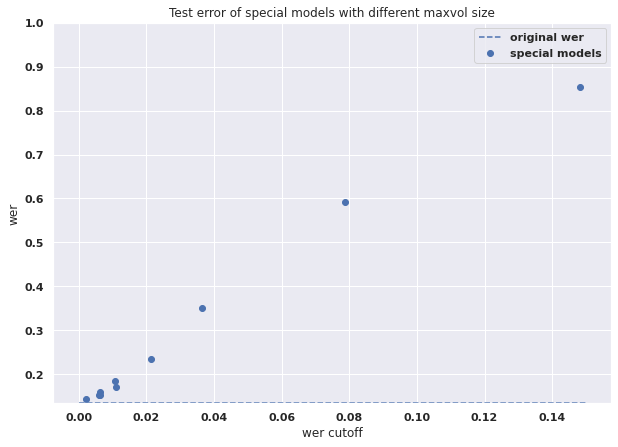

In [42]:
plt.figure(figsize=(10, 7))
x = special_wer_cutoffs[special_rank_specs.keys()]
y = eval_results[special_rank_specs.keys()].apply(lambda x: x[1])
plt.ylim([original_values['wer'], None])
plt.plot([0, 0.15], [original_values['wer'], original_values['wer']], '--', label='original wer')
plt.scatter(x, y, label='special models')
# label_point(x, y, list(special_rank_specs.keys()), plt.gca())
plt.xlabel('wer cutoff')
plt.ylabel('wer')
plt.legend()
plt.title(f'Test error of special models with different maxvol size')
plt.show()

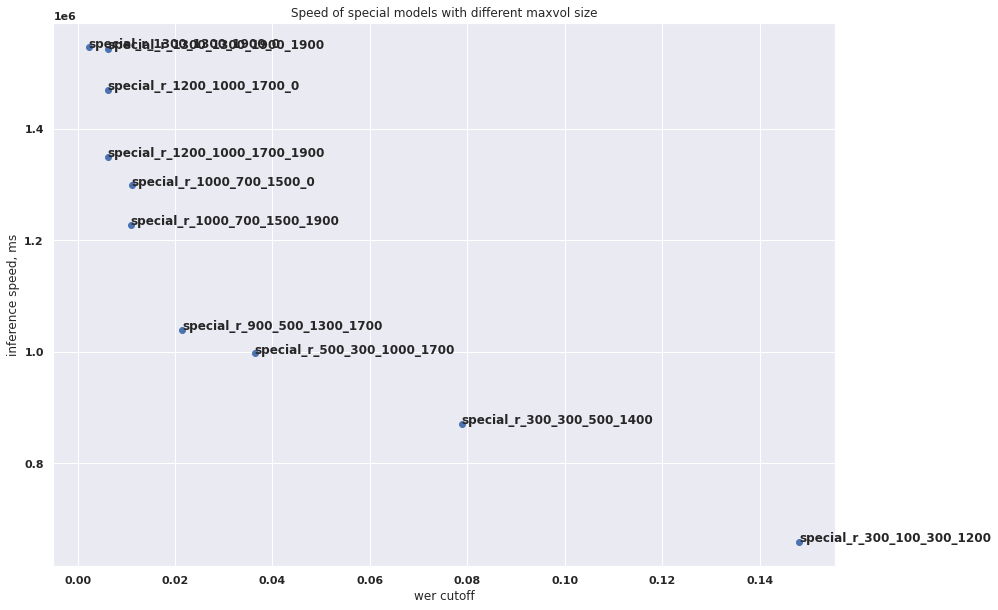

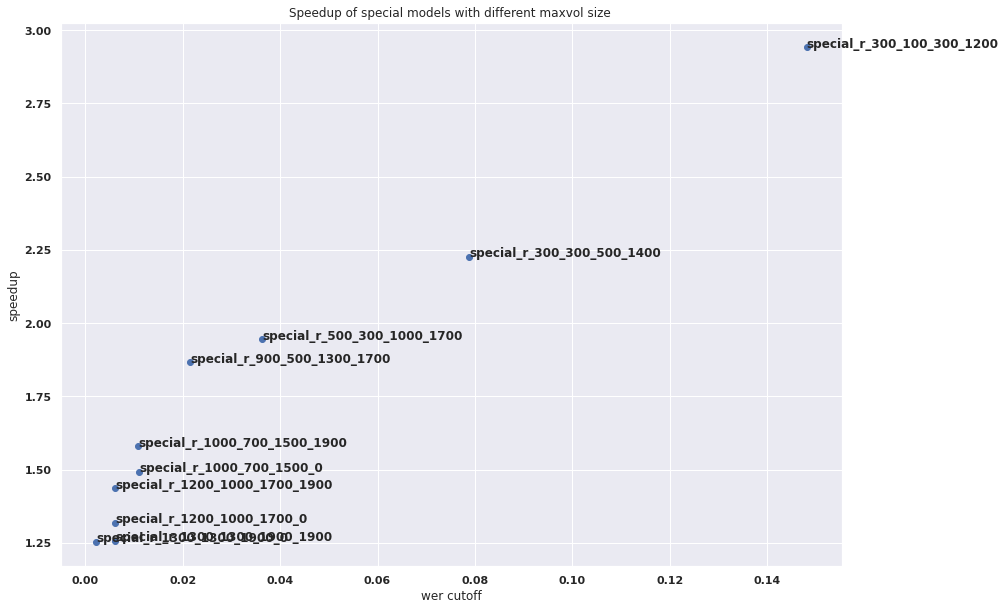

In [43]:
with open('./maxvol_stats/speeduptest_with_tol_special_.pickle', 'rb') as f:
    special_speed_data = pd.Series(pickle.load(f))
    
plt.figure(figsize=(14,10))
x = special_wer_cutoffs[special_rank_specs.keys()]
y = special_speed_data[special_rank_specs.keys()].apply(lambda x: x[0])
plt.scatter(x, y)
label_point(x, y, list(special_rank_specs.keys()), plt.gca())
plt.xlabel('wer cutoff')
plt.ylabel('inference speed, ms')
plt.title(f'Speed of special models with different maxvol size')
plt.show()    

plt.figure(figsize=(14,10))
x = special_wer_cutoffs[special_rank_specs.keys()]
y = original_values['inference_time'] / special_speed_data[special_rank_specs.keys()].apply(lambda x: x[0])
plt.scatter(x, y)
label_point(x, y, list(special_rank_specs.keys()), plt.gca())
plt.xlabel('wer cutoff')
plt.ylabel('speedup')
plt.title(f'Speedup of special models with different maxvol size ')
plt.show()    

# Speedup plot

In [44]:
def get_run_rank(name):
    return int(name[name.index('_r') + 2:])

def get_run_name(name):
    return name[:name.index('_2vol_tol')]

def get_run_tol(name):
    tol_start = name.index('_tol') + 4
    tol_end = name.index('_', tol_start)
    return float(name[tol_start:tol_end])

def get_run_maxvol_type(name):
    if '2vol' in name:
        return '2vol'
    elif '1vol' in name:
        return '1vol'
    else:
        raise ValueError(f"Name {name} is incorrect")

def is_full_change(name):
    return name.startswith('lstm_desnse234_')

def get_inf_times(ranks, maxvol_type, speed_data):
    inference_times = []
    for rank in ranks:
        inference_times.append(speed_data[f'lstm_desnse234_{maxvol_type}_maxvolled_deepspeech_r{rank}'][0])
    return np.array(inference_times)

In [45]:
with open('./maxvol_stats/speeduptest_with_tol_.pickle', 'rb') as f:
    speed_data = pickle.load(f)
    
full_change_ranks = []
full_change_tol = []
full_change_avg = []
full_change_std = []
full_change_maxvol_type = []
for result_name, result_data in speed_data.items():
    if is_full_change(result_name):
        full_change_ranks.append(get_run_rank(result_name))
        full_change_tol.append(get_run_tol(result_name))
        full_change_avg.append(result_data[0])
        full_change_std.append(result_data[1])
        full_change_maxvol_type.append(get_run_maxvol_type(result_name))
speed_results = pd.DataFrame.from_dict({
    'avg': full_change_avg,
    'std': full_change_std,
    'rank': full_change_ranks,
    'maxvol_type': full_change_maxvol_type,
    'tol': full_change_tol
})
speed_results.sort_values('rank', inplace=True)

In [46]:
with open('./maxvol_stats/speeduptest_with_tol_special_.pickle', 'rb') as f:
    special_lspeed_data = pickle.load(f)
    
full_change_ranks = []
full_change_tol = []
full_change_avg = []
full_change_std = []
full_change_maxvol_type = []
for result_name, result_data in speed_data.items():
    if is_full_change(result_name):
        full_change_ranks.append(get_run_rank(result_name))
        full_change_tol.append(get_run_tol(result_name))
        full_change_avg.append(result_data[0])
        full_change_std.append(result_data[1])
        full_change_maxvol_type.append(get_run_maxvol_type(result_name))
speed_results = pd.DataFrame.from_dict({
    'avg': full_change_avg,
    'std': full_change_std,
    'rank': full_change_ranks,
    'maxvol_type': full_change_maxvol_type,
    'tol': full_change_tol
})
speed_results.sort_values('rank', inplace=True)

In [48]:
def print_speedup_wer_plot(ax, xlim=None, ylim=None, plot_ranks=False, tols=[1.01, 1.05,1.1]):
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    
    ranks = list(reversed([300, 500, 700, 1000, 1200, 1400, 1500, 1700]))
    for maxvol_type in ['2vol']:
        for tol in tols:
            wers = np.load(f'./maxvol_stats/{maxvol_type}_tol{tol}_wers.npy')[:len(ranks)] - original_values['wer']
            curr_results = speed_results[(speed_results['maxvol_type']==maxvol_type) & (speed_results['tol']==tol)]
            curr_results.set_index('rank', inplace=True)
            speedups = original_values['inference_time'] / curr_results.loc[ranks, 'avg']
            ax.scatter(speedups, wers, label=f'{maxvol_type} tol={tol}')
            if plot_ranks:
                label_point(speedups, wers, ranks, plt.gca())
    
    ax.set_ylabel('Drop in WER')
    ax.set_xlabel('speedup')
#     ax.set_title(f'Error for maxvol decomposition of all layers')

def print_special_speedup_wer_plot(ax, xlim=None, ylim=None, plot_names=False):
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    x = original_values['inference_time'] / special_speed_data[special_rank_specs.keys()].apply(lambda x: x[0])
    y = eval_results[special_rank_specs.keys()].apply(lambda x: x[1]) - original_values['wer']
    plt.scatter(x, y, label='adaptive maxvol size')
    if plot_names:
        label_point(x, y, map(int, list(special_rank_specs.keys())), plt.gca())

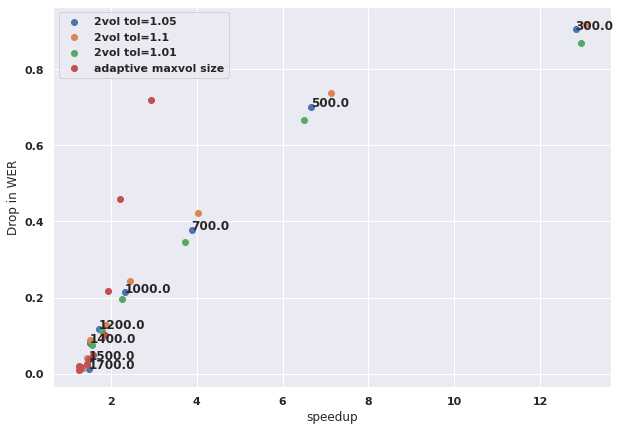

In [57]:
plt.figure(figsize=(10, 7))
print_speedup_wer_plot(plt.gca(), plot_ranks=True, tols=[1.05])
print_speedup_wer_plot(plt.gca(), plot_ranks=False, tols=[1.1, 1.01])
print_special_speedup_wer_plot(plt.gca())
# plt.ylim([original_values['wer'], None])
# plt.plot([0, 15], [original_values['wer'], original_values['wer']], '--', label='original wer')
plt.gca().legend()

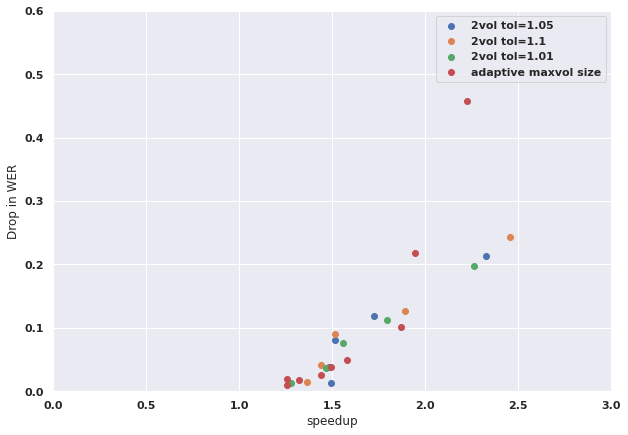

In [58]:
plt.figure(figsize=(10, 7))
print_speedup_wer_plot(plt.gca(), plot_ranks=False, tols=[1.05], ylim=[0, 0.6], xlim=[0,3])
print_speedup_wer_plot(plt.gca(), plot_ranks=False, tols=[1.1, 1.01], ylim=[0, 0.6], xlim=[0,3])
print_special_speedup_wer_plot(plt.gca())
# plt.ylim([original_values['wer'], None])
# plt.plot([0, 3], [original_values['wer'], original_values['wer']], '--', label='original wer')
plt.gca().legend()